In [2]:
from opt.mc_sim import *
import time
from common.variables import *

In [62]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
sourcingEnv = SourcingEnv(
        lambda_arrival = LAMBDA, # or 10
        procurement_cost_vec = np.array([3, 1]),
        supplier_lead_times_vec = np.array([0.8, 0.5]),
        on_times = np.array([1, 1]), 
        off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_ss_policy(sourcingEnv, start_state = s_custom, 
    periods = 40,
    nested_mc_iters = 50,
    big_s = 10,
    small_s = 3)

# print(mc_avg_costs)

In [63]:
print(s_custom)

Stock: 0, n backorders: [0 0], supplier status (on/off): [1 1]


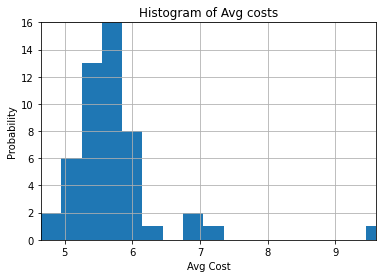

In [64]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [65]:
print(np.mean(np.array(mc_avg_costs)))

5.7139999999999995


In [66]:
np.std(np.array(mc_avg_costs))

0.730464920444507

In [11]:
print(sourcingEnv.reset())

Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]


In [12]:
repr(str(sourcingEnv.reset()))

"'Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]'"

In [4]:
import pickle as pkl
from opt.eval_policy import *

# filename = "output/msource_value_dic_06-16-2022-09-56-03.pkl"
filename = "output/msource_value_dic_06-18-2022-00-58-16.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]

In [7]:
value_dic

{'[2, 0, 0, 0, 0]': -7.9298747375293095,
 '[2, 0, 0, 0, 1]': -8.006149187445317,
 '[2, 0, 0, 1, 0]': -7.974517063207981,
 '[2, 0, 0, 1, 1]': -7.87304994137197,
 '[2, 0, 1, 0, 0]': -7.915767324923891,
 '[2, 0, 1, 0, 1]': -7.543679289845528,
 '[2, 0, 1, 1, 0]': -7.629300635509066,
 '[2, 0, 1, 1, 1]': -7.569043679417258,
 '[2, 0, 2, 0, 0]': -7.559174278480472,
 '[2, 0, 2, 0, 1]': -7.595821136120506,
 '[2, 0, 2, 1, 0]': -7.475633688269366,
 '[2, 0, 2, 1, 1]': -7.482952166505321,
 '[2, 0, 3, 0, 0]': -7.513736508410318,
 '[2, 0, 3, 0, 1]': -7.4697893237026545,
 '[2, 0, 3, 1, 0]': -7.824945516367325,
 '[2, 0, 3, 1, 1]': -7.778361112824418,
 '[2, 0, 4, 0, 0]': -7.3972718154337676,
 '[2, 0, 4, 0, 1]': -7.649684812872987,
 '[2, 0, 4, 1, 0]': -7.561819164954746,
 '[2, 0, 4, 1, 1]': -7.810705970673211,
 '[2, 0, 5, 0, 0]': -7.6629809671828175,
 '[2, 0, 5, 0, 1]': -7.4924097617838505,
 '[2, 0, 5, 1, 0]': -7.656849661140186,
 '[2, 0, 5, 1, 1]': -7.623572197891523,
 '[2, 0, 6, 0, 0]': -7.6110660186981

In [5]:
eval_steps = 40
mc_eval_iter = 50
eval_costs = mc_eval_policy_from_value_dic(sourcingEnv, value_dic, 
    max_steps = eval_steps, mc_iters = mc_eval_iter)

avg_eval_cost = np.mean(eval_costs)

NameError: name 'sourcingEnv' is not defined

In [73]:
eval_costs_scaled = np.array(eval_costs)/len(eval_costs)

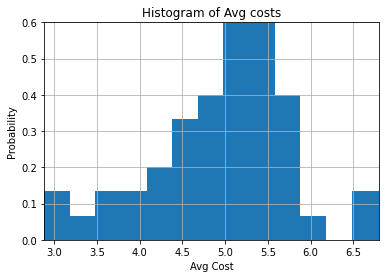

In [74]:
import numpy as np

binwidth = 0.3

n, bins, patches = plt.hist(eval_costs_scaled, bins=np.arange(min(eval_costs_scaled), max(eval_costs_scaled) + binwidth, binwidth), density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(eval_costs_scaled), np.max(eval_costs_scaled))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [75]:
np.mean(eval_costs_scaled)

5.0392

In [76]:
np.std(eval_costs_scaled)

0.8709072051602283

-7.037139689578714

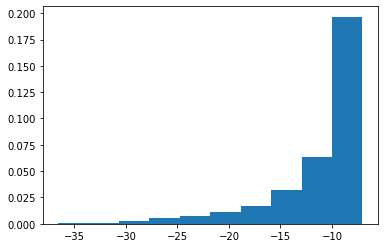

In [61]:
import numpy as np

binwidth = 0.3

state_vals = list(value_dic.values())

n, bins, patches = plt.hist(state_vals, density = True)
np.max(state_vals)